* [OASIS-1 Dataset](#OASIS-1)<br>
* [Environment Setup and Data Import](#Environment-Setup-and-Data-Import)<br>
* [Convoluted Neural Network for Diagnosis](#Convoluted-Neural-Network-for-Diagnosis)<br>
* [t-Distributed Stochastic Neighbor Embedding](#t-SNE-Dimensionality-Reduction)<br>
* [Principal Component Analysis](#Principal-Component-Analysis)<br>
* [Predicting with Categorical Features](#OASIS-1-Demographic-Data-and-Derived-Anatomical-Measures)<br>
* [Results](#Results)<br>

# OASIS-1
___

**Summary:** This set consists of a cross-sectional collection of 416 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.
<br><br>
For analysis, AD patients were upsampled to balance the dataset.
<br><br>
### Diagnosis Labeling<br>
___
Clinical Dementia Ratings (CDR) are provided in the dataset with the following attributions:
> 0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD<br>

For the purpose of analysis, all patients with a CDR of 0 are giving a diagnosis of 0, denoting cognitively healthy. CDR ratings above 0 are converted to 1, for an AD diagnosis, and binary classification.

```python
diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' }
```

### MRI Images<br>
___
This study uses transverse orientation cuts taken from a three-dimensional MRI stack. The images have been altered with a mask such that each voxel is assigned a value between 0 and 5.

# Environment Setup and Data Import
___

In [1]:
import random
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

from ann_visualizer.visualize import ann_viz;
from sklearn.tree import export_graphviz
import graphviz

from matplotlib.pyplot import imread
import matplotlib
import numpy as np
import os
import imageio
import cv2
from random import seed
seed(42)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import tensorflow
import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.initializers import he_normal
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, Input
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from numpy.testing import assert_allclose
import nibabel as nib
from nibabel.testing import data_path
from PIL import Image
import nilearn
from nilearn import image, plotting
import ggplot
from ggplot import aes, geom_point, ggtitle

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for mo

In [2]:
def get_slice(): # read in OASIS-1 MRI data across discs
    path = 'Discs/'
    disc_list = os.listdir(path) # get list of discs from directory
    MacOS_file = '.DS_Store'
    if MacOS_file in disc_list:
        disc_list.remove(MacOS_file) # remove MacOS file

    brain_list, total_subjects = [], [] # generate list of brain images for input to NN, all subjects used in study
    
    for disc in disc_list:
        path_ind_disc = f'{path}/{disc}'
        subject_list_p_disc = os.listdir(path_ind_disc) # generate list of subjects in each disc
        if MacOS_file in subject_list_p_disc:
            subject_list_p_disc.remove(MacOS_file) # remove MacOS file
            
        for subj_id in subject_list_p_disc:
            total_subjects.append(subj_id) # maintain a list of all subjects included in study for diagnosis labeling later
    
            path_n4 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n3 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n6 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n5 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            
            path_list = [path_n4,path_n3, path_n6,path_n5]
            for i in path_list:
                if os.path.exists(i) == True:
                    brain_list.append(plt.imread(i)) # append if file format exists

    return disc_list, brain_list, total_subjects

In [3]:
disc_list, brain_list, total_subjects = get_slice()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc12/OAS1_0448_MR1/FSL_SEG/OAS1_0448_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc12/OAS1_0449_MR1/FSL_SEG/OAS1_0449_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc12/OAS1_0439_MR1/FSL_SEG/OAS1_0439_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc11/OAS1_0395_MR2/FSL_SEG/OAS1_0395_MR2_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc11/OAS1_0406_MR1/FSL_SEG/OAS1_0406_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc11/OAS1_0413_MR1/FSL_SEG/OAS1_0413_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc5/OAS1_0157_MR1/FSL_SEG/OAS1_0157_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc5/OAS1_0156_MR1/FSL_SEG/OAS1_0156_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs//disc5/OAS1_0181_MR1/FSL_SEG/OAS1_0181_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io

In [4]:
def get_diagnosis(total_subjects): # builds a dictionary of subjects and diagnoses
    oasis1 = pd.read_csv('oasis_cross-sectional.csv') # read in summary file
    oasis1['CDR'].fillna(0, inplace=True) # null values are healthy diagnoses
    diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' } # convert diagnosis to labels
    oasis1.replace({"CDR": diagnosis_qual}, inplace=True)
    diagnosis_quant={'normal':0,'AD':1} # convert diagnosis to numerical values
    oasis1.replace({"CDR": diagnosis_quant}, inplace=True)
    oasis1['Subject'] =pd.DataFrame([subj[0:9] for subj in oasis1['ID']]) # extract subject ID from MR ID
    
    subjects = [subj[0:9] for subj in total_subjects] # get subject names for each MRI ID
    subjects = pd.DataFrame(subjects, columns = ['Subject']) # convert to dataframe
    
    diagnosis_dict= {oasis1['Subject'][num]: oasis1['CDR'][num] for num in range(0, 436)} # create a dictionary with subject and diagnosis
    diag = [diagnosis_dict[subj] for subj in subjects['Subject']] # create a list of diagnoses to append to dataframe of subjects
    subjects['Diagnosis'] = pd.DataFrame(diag)
    
    return subjects, diagnosis_dict

In [5]:
subjects, diagnosis_dict = get_diagnosis(total_subjects)

In [6]:
def balance_set(subjects, total_subjects, disc_list): # balance the data
    AD_subjects = subjects.sort_values(by='Diagnosis', ascending = False).head(97) # all subjects diagnosed as AD
    AD_subjects = AD_subjects.append(AD_subjects)
    head = AD_subjects.head(42) # upsample to balance
    AD_subjects = AD_subjects.append(head)    
    
    for subj in AD_subjects['Subject']:
        total_subjects.append(str(subj) + '_MR1') # maintain a list of all subjects included in study for diagnosis labeling later
    for disc in disc_list:
            path = f'Discs/{disc}'

            for i in AD_subjects['Subject']:

                path_n4 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n3 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n6 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n5 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'

                path_list = [path_n4,path_n3, path_n6,path_n5]
                for i in path_list:
                    if os.path.exists(i) == True:
                        brain_list.append(plt.imread(i)) # append if file format exists

    brain_array = np.asarray(brain_list)
    return brain_array, AD_subjects

In [7]:
brain_array, AD_subjects = balance_set(subjects, total_subjects, disc_list) 
subjects, diagnosis_dict = get_diagnosis(total_subjects)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs/disc12/OAS1_0440_MR1/FSL_SEG/OAS1_0440_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs/disc12/OAS1_0454_MR1/FSL_SEG/OAS1_0454_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs/disc12/OAS1_0441_MR1/FSL_SEG/OAS1_0441_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs/disc2/OAS1_0056_MR1/FSL_SEG/OAS1_0056_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs/disc2/OAS1_0053_MR1/FSL_SEG/OAS1_0053_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='Discs/disc5/OAS1_0185_MR1/FSL_SEG/OAS1_0185_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.Bu

# Convoluted Neural Network for Diagnosis
___

Here, a convoluted neural network (CNN) is trained on the balanced set of fMRI images to predict the diagnosis of Alzheimer's Disease. The network consists of three spatial convolution layers and three max pooling layers. The convolution layers create a convolution kernel that is convolved with the layer input to produce a tensor of outputs. In each layer, a sigmoid activation is applied to the outputs. In addition, the max pooling layers apply a specific stride to down-sample the input images at each stage.

The performance of the CNN is shown in the results section.

# Visualizing the Input

This section shows a small sample of the images as they are fed into the CNN. Those labeled as 'Classification: 0' are cognitively healthy and those labeled with 'Classification: 1' have an Alzheimer's Disease diagnosis.

                                  Test Images                                   


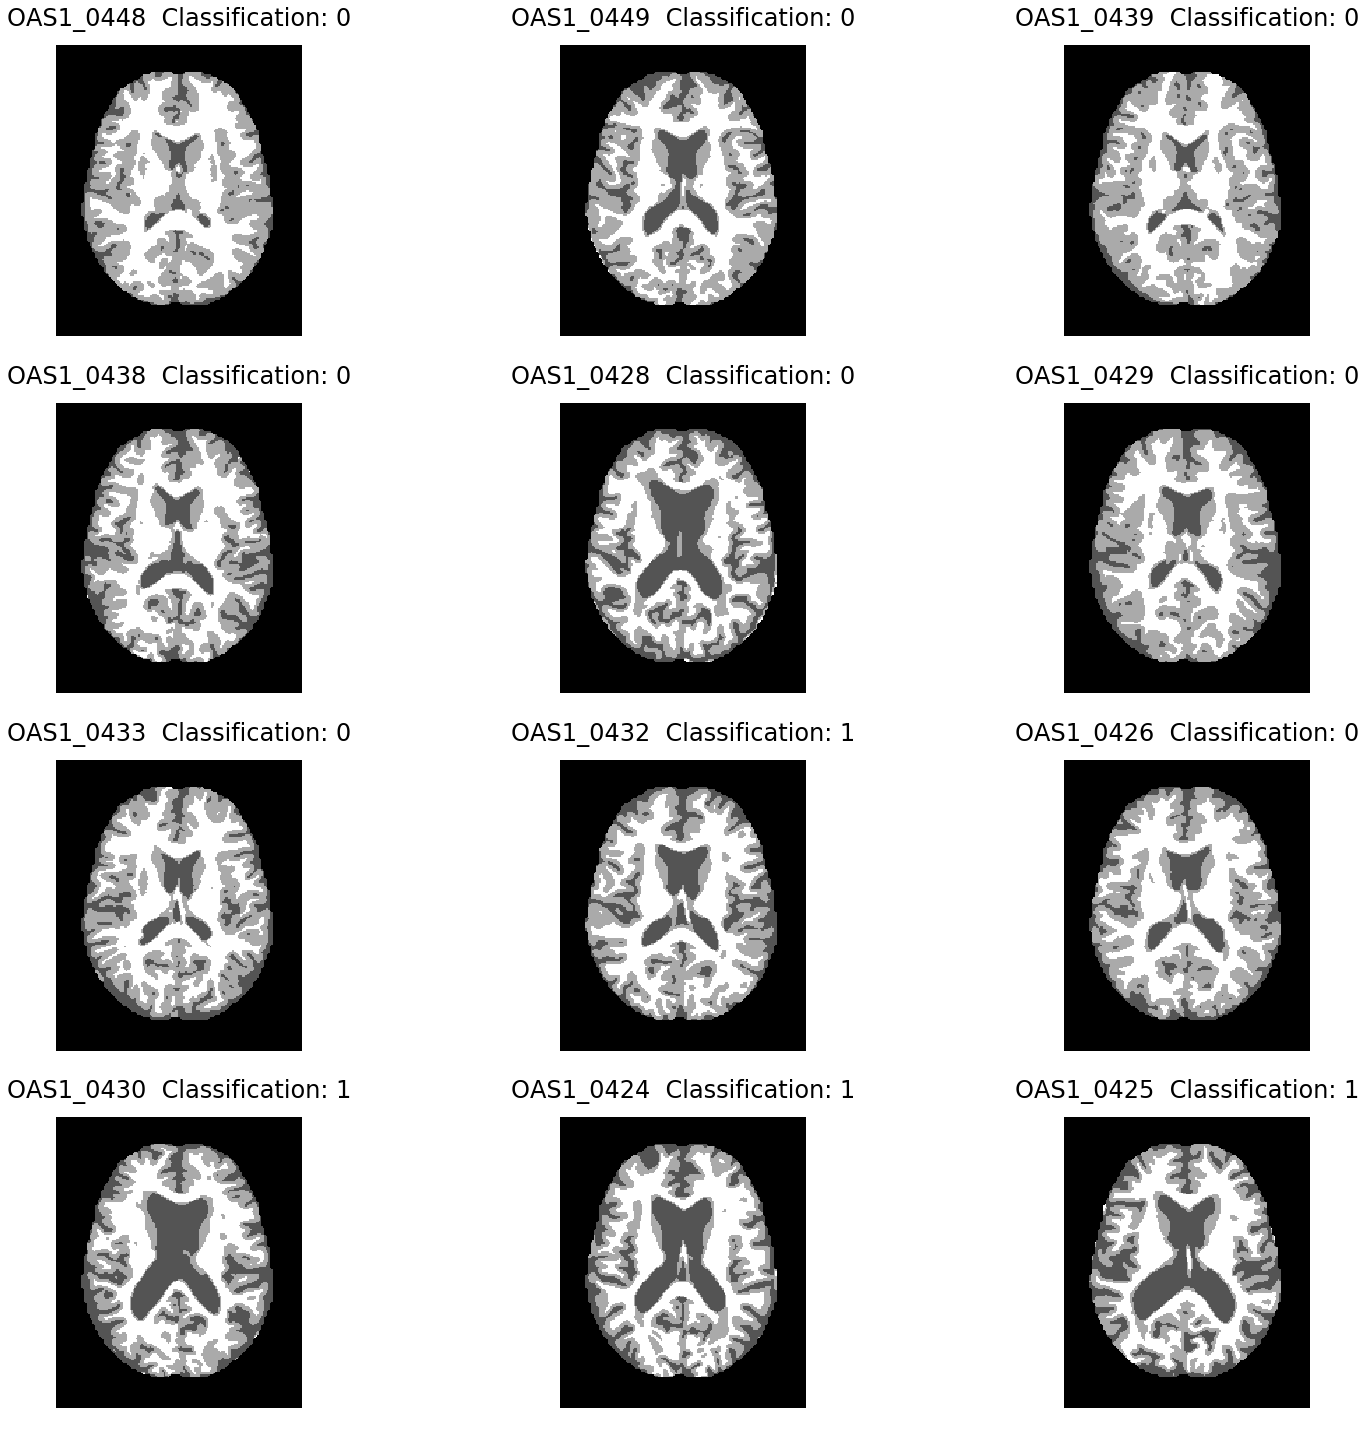

In [8]:
def plot_test_images(subject, diagnosis, array):
    plt.figure(figsize = (20, 20))
    print("Test Images".center(os.get_terminal_size().columns))
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title(str(subject[i]) +'  Classification: ' + str(diagnosis[i]), fontsize=24, pad = 20)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(array[i], cmap = 'gray')
        plt.subplots_adjust(wspace = 0.25)
    plt.show()  
    
plot_test_images(subjects['Subject'], subjects['Diagnosis'], brain_array)

In [9]:
x_MRI = brain_array # array of image values
y_MRI = np.asarray(subjects['Diagnosis']) # diagnosis for each subject
x_MRI = x_MRI.reshape(-1, 208, 176,1)

norm = lambda x :(x - np.min(x)) / (np.max(x) - np.min(x)) # normalize x values
x_MRI_norm = norm(x_MRI)
assert (np.min(x_MRI_norm), np.max(x_MRI_norm)) == (0.0, 1.0) # check min and max values
x_MRI_train, x_MRI_test, y_MRI_train, y_MRI_test = train_test_split(x_MRI_norm, y_MRI, random_state = 42) # split into test and train sets

In [10]:
input_shape = (208,176,1)

model = Sequential()
model.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10),
                 activation='sigmoid', padding ='same',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(50, (3, 3), activation='sigmoid', strides=(5,5), padding ='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(25, kernel_size=(3,3), activation='sigmoid', strides = (1,1), padding ='same'))
model.add(MaxPooling2D(pool_size=(1, 1), padding='valid'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

EarlyStopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto') # stop when loss no longer improving

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_MRI_train, y_MRI_train, epochs=600, batch_size=75, callbacks=[EarlyStopping])

Epoch 1/600
499/499 [==============================] - 1s 2ms/step - loss: 0.7059 - acc: 0.4489
Epoch 2/600
499/499 [==============================] - 1s 1ms/step - loss: 0.6938 - acc: 0.4990
Epoch 3/600
499/499 [==============================] - 0s 961us/step - loss: 0.6936 - acc: 0.4830
Epoch 4/600
499/499 [==============================] - 1s 1ms/step - loss: 0.6936 - acc: 0.5010
Epoch 5/600
499/499 [==============================] - 0s 999us/step - loss: 0.6933 - acc: 0.5010
Epoch 6/600
499/499 [==============================] - 1s 1ms/step - loss: 0.6933 - acc: 0.4830
Epoch 7/600
499/499 [==============================] - 1s 1ms/step - loss: 0.6936 - acc: 0.4689A: 0s - loss: 0.6935 - acc: 0.46
Epoch 8/600
499/499 [==============================] - 1s 1ms/step - loss: 0.6935 - acc: 0.4729
Epoch 9/600
499/499 [==============================] - 1s 1ms/step - loss: 0.6933 - acc: 0.4870
Epoch 10/600
499/499 [==============================] - 1s 1ms/step - loss: 0.6934 - acc: 0.5010
Epo

499/499 [==============================] - 1s 1ms/step - loss: 0.4184 - acc: 0.8136
Epoch 85/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4154 - acc: 0.8236
Epoch 86/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4172 - acc: 0.8176
Epoch 87/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4101 - acc: 0.8176
Epoch 88/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4127 - acc: 0.8216
Epoch 89/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4137 - acc: 0.8357
Epoch 90/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4219 - acc: 0.8297
Epoch 91/600
499/499 [==============================] - 0s 955us/step - loss: 0.4101 - acc: 0.8176
Epoch 92/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4063 - acc: 0.8136A: 0s - loss: 0.4045 - acc: 0.817
Epoch 93/600
499/499 [==============================] - 1s 1ms/step - loss: 0.4066 - acc: 0.8196
Epoch 94

499/499 [==============================] - 1s 1ms/step - loss: 0.3681 - acc: 0.8557
Epoch 168/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3660 - acc: 0.8437
Epoch 169/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3664 - acc: 0.8437
Epoch 170/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3706 - acc: 0.8517
Epoch 171/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3682 - acc: 0.8497
Epoch 172/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3694 - acc: 0.8477
Epoch 173/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3797 - acc: 0.8437
Epoch 174/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3791 - acc: 0.8297
Epoch 175/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3869 - acc: 0.8437
Epoch 176/600
499/499 [==============================] - 1s 1ms/step - loss: 0.3807 - acc: 0.8417
Epoch 177/600
499/499 [===========

In [11]:
def get_metrics(model, x_test, y_test): # get accuracy, recall, precision
    results = model.evaluate(x_test, y_test)
    accuracy = round(results[1]*100,2)
    y_pred = model.predict_classes(x_test) # predictions for test set
    recall = round((recall_score(y_test, y_pred))*100, 2)
    precision = round(precision_score(y_test, y_pred)*100, 2)
    return accuracy, recall, precision

In [12]:
model_accuracy, model_recall, model_precision = get_metrics(model, x_MRI_test, y_MRI_test)

167/167 [==============================] - 0s 829us/step


In [13]:
ann_viz(model, title="Neural Network for MRI Classification"); # visualize CNN

/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 47701 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 47703 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 47713 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 47715 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 47717 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 47719 is still running
  ResourceWarning, source=self)
/Users/glynismattheisen/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 47721

# t-SNE Dimensionality Reduction
___

T-distributed Stochastic Neighbor Embedding (t-SNE) was tested as a nonlinear dimensionality reduction technique to improve the results of the CNN. t-SNE calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space then optimizes these similarity measures using a cost function. Essentially, t-SNE embeds high-dimensional data in a low-dimensional space. After applying the t-SNE transformation to the fMRI images, a deeply connected NN of four dense layers is trained with this new input. 

The performance outcome of the NN trained on t-SNE images is shown in the results section.

In [14]:
x_MRI = x_MRI[:,:,:,0]
tsne = TSNE(n_components=2, init='pca', random_state=42) # initialize t-SNE
assert x_MRI.shape == (666, 208, 176) # check shape
x_tsne = tsne.fit_transform(x_MRI.reshape((666,208*176))) # fit data

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [15]:
x_tsne_train, x_tsne_test, y_tsne_train, y_tsne_test = train_test_split(x_tsne,y_MRI, random_state = 42)
he = keras.initializers.he_normal(seed=42)   
model_tsne = Sequential([
Dense(50, input_shape=(2,), kernel_initializer=he),
Activation('sigmoid'),
Dense(20),
Activation('sigmoid'),
Dense(10),
Activation('sigmoid'),
Dense(1),
Activation('sigmoid'),
])

optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
model_tsne.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
model_tsne.fit(x_tsne_train, y_tsne_train, epochs=500, batch_size=50, callbacks=[EarlyStopping])

Epoch 1/500
499/499 [==============================] - 1s 1ms/step - loss: 0.6611 - acc: 0.6794
Epoch 2/500
499/499 [==============================] - 0s 88us/step - loss: 0.5473 - acc: 0.8176
Epoch 3/500
499/499 [==============================] - 0s 78us/step - loss: 0.4860 - acc: 0.8136
Epoch 4/500
499/499 [==============================] - 0s 102us/step - loss: 0.4540 - acc: 0.8156
Epoch 5/500
499/499 [==============================] - 0s 60us/step - loss: 0.4319 - acc: 0.8236
Epoch 6/500
499/499 [==============================] - 0s 82us/step - loss: 0.4197 - acc: 0.8297
Epoch 7/500
499/499 [==============================] - 0s 49us/step - loss: 0.4095 - acc: 0.8357
Epoch 8/500
499/499 [==============================] - 0s 44us/step - loss: 0.4056 - acc: 0.8377
Epoch 9/500
499/499 [==============================] - 0s 81us/step - loss: 0.4014 - acc: 0.8377
Epoch 10/500
499/499 [==============================] - 0s 57us/step - loss: 0.3964 - acc: 0.8377
Epoch 11/500
499/499 [=======

499/499 [==============================] - 0s 62us/step - loss: 0.3401 - acc: 0.8417
Epoch 85/500
499/499 [==============================] - 0s 111us/step - loss: 0.3392 - acc: 0.8397
Epoch 86/500
499/499 [==============================] - 0s 95us/step - loss: 0.3373 - acc: 0.8497
Epoch 87/500
499/499 [==============================] - 0s 88us/step - loss: 0.3351 - acc: 0.8477
Epoch 88/500
499/499 [==============================] - 0s 64us/step - loss: 0.3350 - acc: 0.8417
Epoch 89/500
499/499 [==============================] - 0s 90us/step - loss: 0.3388 - acc: 0.8477
Epoch 90/500
499/499 [==============================] - 0s 124us/step - loss: 0.3390 - acc: 0.8457
Epoch 91/500
499/499 [==============================] - 0s 111us/step - loss: 0.3335 - acc: 0.8477
Epoch 92/500
499/499 [==============================] - 0s 66us/step - loss: 0.3331 - acc: 0.8477
Epoch 93/500
499/499 [==============================] - 0s 329us/step - loss: 0.3330 - acc: 0.8457
Epoch 94/500
499/499 [=======

In [17]:
tsne_accuracy, tsne_recall, tsne_precision = get_metrics(model_tsne, x_tsne_test, y_tsne_test)

167/167 [==============================] - 0s 1ms/step


# Visualizing the t-SNE Images

<Figure size 432x288 with 0 Axes>

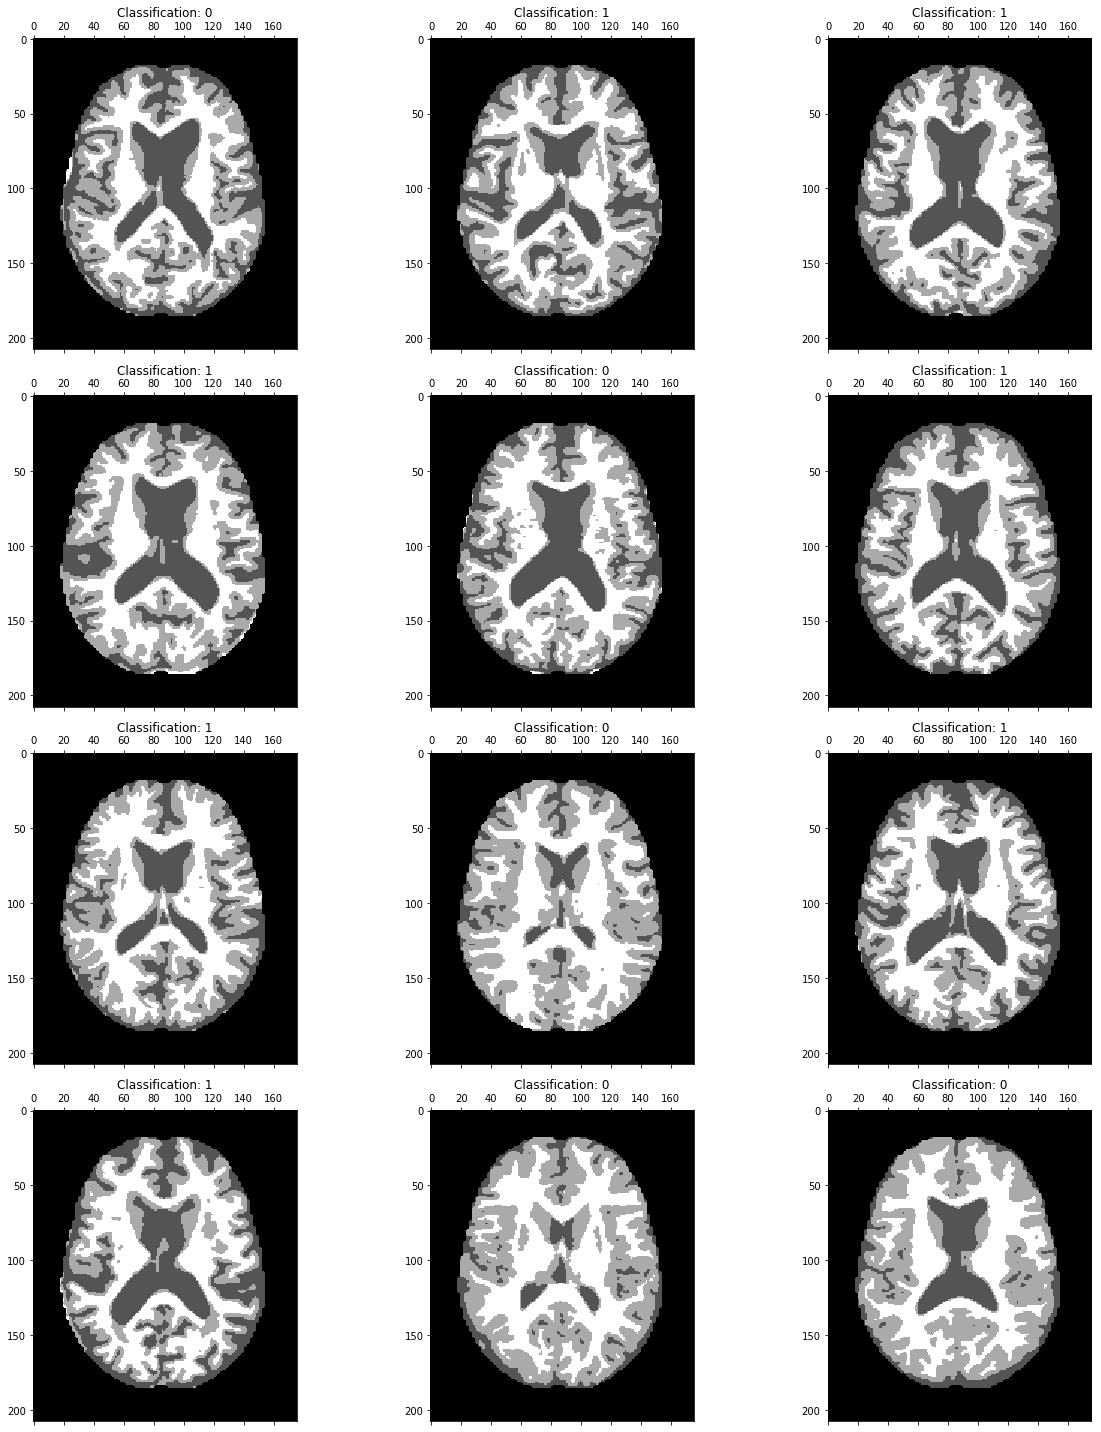

In [18]:
x = x_MRI.reshape((666,208*176))
feat_cols = ['pixel'+str(i) for i in range(x.shape[1])] # name each column a pixel number
df = pd.DataFrame(x, columns=feat_cols) # convert X to dataframe
df['label'] = y_MRI
df['label'] = df['label'].apply(lambda i: str(i)) 
rndperm = np.random.permutation(df.shape[0])

plt.gray()
fig = plt.figure(figsize = (20,20))
for i in range(0,12):
    ax = fig.add_subplot(4, 3, i+1, title='Classification: ' + str(df.loc[rndperm[i], 'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((208,176)).astype(float))
    plt.tight_layout()
plt.show()

# Principal Component Analysis
___

Primary Component Analysis (PCA) was tested as a second dimensionality reduction technique to improve results over the CNN. PCA is a linear dimensionality reduction technique that maximizes variance in the data for feature extraction. After applying a PCA transformation to the fMRI images, a deeply connected NN of four dense layers is trained with this new input. 

The performance outcome of the NN trained on PCA images is shown in the results section.

In [19]:
m_PCA = PCA(n_components=10)
m_PCA.fit(x) # fit data with PCA algorithm
xt = m_PCA.transform(x)
xback = m_PCA.inverse_transform(xt)
assert x.shape == xback.shape
xback = xback.reshape((666,208,176))

In [20]:
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(xt,y_MRI, random_state = 42) # train CNN on 

he = keras.initializers.he_normal(seed=42)    

model_PCA = Sequential([
Dense(100, input_shape=(10,), kernel_initializer=he),
Activation('sigmoid'),
Dense(30),
Activation('sigmoid'),
Dense(15),
Activation('sigmoid'),
Dense(1),
Activation('sigmoid'),
])

optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_PCA.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [21]:
model_PCA.fit(X_PCA_train,y_PCA_train,epochs=500, batch_size=50, callbacks=[EarlyStopping])

Epoch 1/500
499/499 [==============================] - 1s 2ms/step - loss: 0.6010 - acc: 0.7615
Epoch 2/500
499/499 [==============================] - 0s 132us/step - loss: 0.4256 - acc: 0.8337
Epoch 3/500
499/499 [==============================] - 0s 94us/step - loss: 0.3666 - acc: 0.8557
Epoch 4/500
499/499 [==============================] - 0s 54us/step - loss: 0.3306 - acc: 0.8798
Epoch 5/500
499/499 [==============================] - 0s 55us/step - loss: 0.3059 - acc: 0.8898
Epoch 6/500
499/499 [==============================] - 0s 122us/step - loss: 0.3024 - acc: 0.8878
Epoch 7/500
499/499 [==============================] - 0s 69us/step - loss: 0.2898 - acc: 0.8938
Epoch 8/500
499/499 [==============================] - 0s 58us/step - loss: 0.2843 - acc: 0.8938
Epoch 9/500
499/499 [==============================] - 0s 75us/step - loss: 0.2781 - acc: 0.8998
Epoch 10/500
499/499 [==============================] - 0s 66us/step - loss: 0.2705 - acc: 0.9078
Epoch 11/500
499/499 [======

499/499 [==============================] - 0s 98us/step - loss: 0.0019 - acc: 1.0000
Epoch 85/500
499/499 [==============================] - 0s 95us/step - loss: 0.0018 - acc: 1.0000
Epoch 86/500
499/499 [==============================] - 0s 85us/step - loss: 0.0018 - acc: 1.0000
Epoch 87/500
499/499 [==============================] - 0s 100us/step - loss: 0.0017 - acc: 1.0000
Epoch 88/500
499/499 [==============================] - 0s 67us/step - loss: 0.0017 - acc: 1.0000
Epoch 89/500
499/499 [==============================] - 0s 112us/step - loss: 0.0016 - acc: 1.0000
Epoch 90/500
499/499 [==============================] - 0s 82us/step - loss: 0.0015 - acc: 1.0000
Epoch 91/500
499/499 [==============================] - 0s 59us/step - loss: 0.0015 - acc: 1.0000
Epoch 92/500
499/499 [==============================] - 0s 94us/step - loss: 0.0015 - acc: 1.0000
Epoch 93/500
499/499 [==============================] - 0s 100us/step - loss: 0.0014 - acc: 1.0000
Epoch 94/500
499/499 [========

499/499 [==============================] - 0s 67us/step - loss: 3.7623e-04 - acc: 1.0000
Epoch 165/500
499/499 [==============================] - 0s 97us/step - loss: 3.7642e-04 - acc: 1.0000
Epoch 166/500
499/499 [==============================] - 0s 62us/step - loss: 3.6636e-04 - acc: 1.0000
Epoch 167/500
499/499 [==============================] - 0s 83us/step - loss: 3.6043e-04 - acc: 1.0000
Epoch 168/500
499/499 [==============================] - 0s 127us/step - loss: 3.5625e-04 - acc: 1.0000
Epoch 169/500
499/499 [==============================] - 0s 73us/step - loss: 3.5252e-04 - acc: 1.0000
Epoch 170/500
499/499 [==============================] - 0s 78us/step - loss: 3.4605e-04 - acc: 1.0000
Epoch 171/500
499/499 [==============================] - 0s 78us/step - loss: 3.4269e-04 - acc: 1.0000
Epoch 172/500
499/499 [==============================] - 0s 67us/step - loss: 3.3718e-04 - acc: 1.0000
Epoch 173/500
499/499 [==============================] - 0s 71us/step - loss: 3.3280e-

499/499 [==============================] - 0s 75us/step - loss: 1.5531e-04 - acc: 1.0000
Epoch 244/500
499/499 [==============================] - 0s 84us/step - loss: 1.5387e-04 - acc: 1.0000
Epoch 245/500
499/499 [==============================] - 0s 158us/step - loss: 1.5374e-04 - acc: 1.0000
Epoch 246/500
499/499 [==============================] - 0s 96us/step - loss: 1.5152e-04 - acc: 1.0000
Epoch 247/500
499/499 [==============================] - 0s 78us/step - loss: 1.4959e-04 - acc: 1.0000
Epoch 248/500
499/499 [==============================] - 0s 182us/step - loss: 1.4838e-04 - acc: 1.0000
Epoch 249/500
499/499 [==============================] - 0s 89us/step - loss: 1.4717e-04 - acc: 1.0000
Epoch 250/500
499/499 [==============================] - 0s 67us/step - loss: 1.4586e-04 - acc: 1.0000
Epoch 251/500
499/499 [==============================] - 0s 99us/step - loss: 1.4436e-04 - acc: 1.0000
Epoch 252/500
499/499 [==============================] - 0s 156us/step - loss: 1.4287

499/499 [==============================] - 0s 72us/step - loss: 8.0333e-05 - acc: 1.0000
Epoch 323/500
499/499 [==============================] - 0s 52us/step - loss: 7.9771e-05 - acc: 1.0000
Epoch 324/500
499/499 [==============================] - 0s 64us/step - loss: 7.9131e-05 - acc: 1.0000
Epoch 325/500
499/499 [==============================] - 0s 95us/step - loss: 7.8694e-05 - acc: 1.0000
Epoch 326/500
499/499 [==============================] - 0s 137us/step - loss: 7.8189e-05 - acc: 1.0000
Epoch 327/500
499/499 [==============================] - 0s 69us/step - loss: 7.7325e-05 - acc: 1.0000
Epoch 328/500
499/499 [==============================] - 0s 81us/step - loss: 7.6806e-05 - acc: 1.0000
Epoch 329/500
499/499 [==============================] - 0s 95us/step - loss: 7.6286e-05 - acc: 1.0000
Epoch 330/500
499/499 [==============================] - 0s 72us/step - loss: 7.5626e-05 - acc: 1.0000
Epoch 331/500
499/499 [==============================] - 0s 70us/step - loss: 7.5093e-

499/499 [==============================] - 0s 84us/step - loss: 4.6099e-05 - acc: 1.0000
Epoch 402/500
499/499 [==============================] - 0s 71us/step - loss: 4.5766e-05 - acc: 1.0000
Epoch 403/500
499/499 [==============================] - 0s 459us/step - loss: 4.5470e-05 - acc: 1.0000
Epoch 404/500
499/499 [==============================] - 0s 98us/step - loss: 4.5234e-05 - acc: 1.0000
Epoch 405/500
499/499 [==============================] - 0s 87us/step - loss: 4.4920e-05 - acc: 1.0000
Epoch 406/500
499/499 [==============================] - 0s 170us/step - loss: 4.4575e-05 - acc: 1.0000
Epoch 407/500
499/499 [==============================] - 0s 155us/step - loss: 4.4310e-05 - acc: 1.0000
Epoch 408/500
499/499 [==============================] - 0s 69us/step - loss: 4.4067e-05 - acc: 1.0000
Epoch 409/500
499/499 [==============================] - 0s 78us/step - loss: 4.3702e-05 - acc: 1.0000
Epoch 410/500
499/499 [==============================] - 0s 96us/step - loss: 4.3437

499/499 [==============================] - 0s 73us/step - loss: 2.7963e-05 - acc: 1.0000
Epoch 481/500
499/499 [==============================] - 0s 80us/step - loss: 2.7802e-05 - acc: 1.0000
Epoch 482/500
499/499 [==============================] - 0s 54us/step - loss: 2.7632e-05 - acc: 1.0000
Epoch 483/500
499/499 [==============================] - 0s 61us/step - loss: 2.7486e-05 - acc: 1.0000
Epoch 484/500
499/499 [==============================] - 0s 124us/step - loss: 2.7316e-05 - acc: 1.0000
Epoch 485/500
499/499 [==============================] - 0s 90us/step - loss: 2.7135e-05 - acc: 1.0000
Epoch 486/500
499/499 [==============================] - 0s 73us/step - loss: 2.6956e-05 - acc: 1.0000
Epoch 487/500
499/499 [==============================] - 0s 61us/step - loss: 2.6802e-05 - acc: 1.0000
Epoch 488/500
499/499 [==============================] - 0s 118us/step - loss: 2.6651e-05 - acc: 1.0000
Epoch 489/500
499/499 [==============================] - 0s 125us/step - loss: 2.6520

# Visualizing the PCA Images

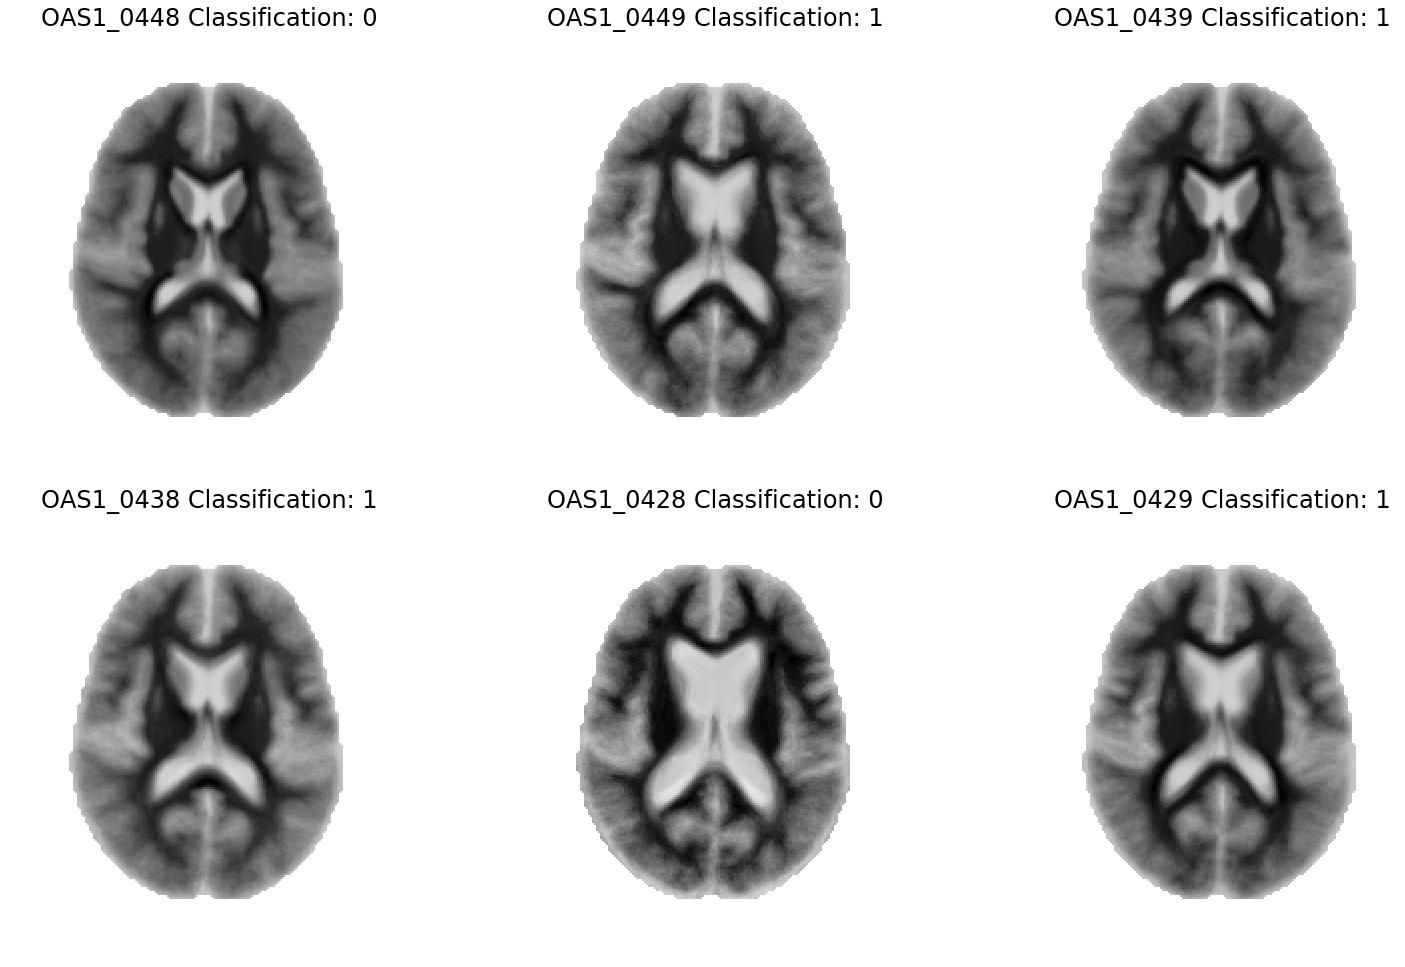

In [22]:
def draw(subject, input):
    plt.figure(figsize=(20,20))

    for i in range(6):
        plt.subplot(3, 3, i+1)
        plt.title(str(subject[i]) + ' Classification: ' + str(df.loc[rndperm[i],'label']), fontsize=24, pad = 20)
        plt.imshow(input[i], cmap=plt.cm.Greys)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.25)
        plt.axis('off')
    plt.show()
    
draw(subjects['Subject'], xback)

In [23]:
PCA_accuracy, PCA_recall, PCA_precision = get_metrics(model_PCA,X_PCA_test, y_PCA_test)

167/167 [==============================] - 0s 1ms/step


# OASIS-1 Demographic Data and Derived Anatomical Measures
___

In this section the accompanying demographic features of the data are used to predict the diagnosis. First, I look at the correlation between clinical dementia rating (CDR) and education, gender, socioeconomic status (SES), and normalized whole brain volume (nWBV). Education and gender are removed from the dataset as they are found to only weakly correlate with the CDR. The values are then used to train a Random Forest Classifier with a grid search employed to select the best hyperparameters. 

In [24]:
df = pd.read_csv('oasis1_cross-sectional.csv') # read in data
df['Subject'] = [subj[0:9] for subj in df['ID']] # extract subject ID from MR ID
del df['ID'] # delete MRI ID in favor of Subject ID
del df['Hand'] # delete handedness
del df['Delay'] # delete MRI delay

In [25]:
df_demo = df[['Subject','M/F','Educ','SES','CDR','nWBV']].copy() # new dataframe containing variables to test

In [26]:
# Identify percentage of each categories composed of missing values
total = df_demo.isnull().sum().sort_values(ascending=False)
percent = df_demo.isnull().sum()/df_demo.isnull().count()*100
pd.concat([total, percent], axis=1, keys=['Total', '%'],sort=True)

,Total,%
CDR,199,46.279070
Educ,199,46.279070
M/F,0,0.000000
SES,218,50.697674
Subject,0,0.000000
nWBV,0,0.000000


In [27]:
df_demo['CDR'].fillna(0, inplace=True) # replace empty entries with 0 for cognitively normal
df_demo['CDR'].replace({0.5:1}, inplace=True) # replace 0.5 CDR values with 1 for AD diagnosis
df_demo['CDR'].replace({2:1}, inplace=True) # replace 2 CDR values with 1 for AD diagnosis

In [28]:
def replace_null(column): # fill null values with MEAN +/- STD
    mean = column.mean()
    std = column.std()
    is_null = column.isnull().sum()
    rand_VAR = np.random.randint(mean - std, mean + std, size = is_null)
    VAR_slice = column.copy()
    VAR_slice[np.isnan(VAR_slice)] = rand_VAR
    column = VAR_slice
    column = column.astype(int)
    return column

In [29]:
df_demo['Educ'] = replace_null(df_demo['Educ']) # fill missing Educ value with MEAN +/- SES
assert df_demo['Educ'].isnull().sum() == 0
df_demo['SES'] = replace_null(df_demo['SES']) # fill missing SES value with MEAN +/- SES
assert df_demo['SES'].isnull().sum() == 0

genders = {"M": 0, "F": 1}
df_demo['M/F'] = df_demo['M/F'].map(genders) # replace male = 0 and female = 1

In [30]:
temp_df = pd.DataFrame() 
for i in AD_subjects['Subject']: # upsample AD patients to balance set
    New_df = df_demo[df_demo['Subject'] == i]
    temp_df = temp_df.append(New_df, ignore_index=True) # moving the contents of newly created dataframe to the temporary dataframe

In [31]:
total_df = df_demo.append(temp_df) # upsample AD patients to balance set
total_df.corr(method= 'pearson') # look at correlations within dataset

,M/F,Educ,SES,CDR,nWBV
M/F,1.000000,-0.082244,0.128726,-0.018493,0.014519
Educ,-0.082244,1.000000,-0.384257,0.072808,-0.166117
SES,0.128726,-0.384257,1.000000,0.305662,-0.354899
CDR,-0.018493,0.072808,0.305662,1.000000,-0.732078
nWBV,0.014519,-0.166117,-0.354899,-0.732078,1.000000


In [32]:
del total_df['M/F'] # delete weakly correlated variable
del total_df['Educ'] # delete weakly correlated variable

total_df.set_index('Subject',inplace=True)

x_text = total_df.drop("CDR", axis=1)
y_text = total_df["CDR"]

assert x_text.shape == (666, 2)
assert y_text.shape == (666,)

# Prediction with Random Forest Classifier

In [33]:
x_text_train, x_text_test, y_text_train, y_text_test = train_test_split(x_text, y_text, random_state = 42)

RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(x_text_train, y_text_train)
print ("Training score: " + str(round(RanFor.score(x_text_train, y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(x_text_test,y_text_test)*100,2)) + '%')

Training score: 87.37%
Test score: 89.22%


In [34]:
random_trees, random_depths =  random.sample(range(1,20),10), random.sample(range(1,50),25)

In [35]:
grid = GridSearchCV(RanFor, 
        param_grid={'n_estimators': random_trees, 'max_depth': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(x_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 89.18% {'max_depth': 18, 'n_estimators': 17}


In [36]:
final_model = grid.best_estimator_
final_model.fit(x_text_train, y_text_train)

print ("Training score: " + str(final_model.score(x_text_train, y_text_train)))
print ("Test score: " + str(final_model.score(x_text_test, y_text_test)))

Training score: 0.9799599198396793
Test score: 0.8922155688622755


In [37]:
RF_text_accuracy = round(final_model.score(x_text_test,y_text_test)*100,2)
txt_pred = final_model.predict(x_text_test)
RF_text_recall = round((recall_score(y_text_test, txt_pred))*100, 2)
RF_text_precision = round(precision_score(y_text_test, txt_pred)*100, 2)

# Oasis 1 Freesurfer Data
___

In this section, more brain volume measures are added from the Freesurfer data and compared to categorical values from the dataset (as seen in the above section) and the subject's diagnosis. I plot how diagnosis correlates with socioeconomic status (SES), gender, education, and three different brain volume measurements (Mask Volume (BrainMaskNVox), Brain Segmentation Volume (BrainSegVol), Normalized Whole Brain Volume (nWBV)). A Random Forest Classifier is then trained on the features for prediction with a grid search employed to optimize the hyperparameters. A visualization tool is used to illustrate the decisions being made in the Random Forest Classifer. 

The performance of the Random Forest Classifier is later compared to the output of the CNN in the results section.

In [38]:
df_free = pd.read_csv('oasis1_FS.csv') # read in freesurfer data

del df_free['FS_ASEGREGIONANALYSIS ID']
del df_free['MR ID']
del df_free['BrainMaskVol'] # delete redundant data
del df_free['BrainSegNVox'] # delete redundant data

diag = [] # create a list of diagnoses to append to freesurfer dataframe
for subj in df_free['Subject']:
    diag.append(diagnosis_dict[subj])

df_free['Diagnosis'] = pd.DataFrame(diag) # add diagnosis to subjects

In [39]:
norm_to_ICV = lambda x : x / df_free['ICV'] # normalize brain volume measurements to intracranial volume

df_free['BrainMaskNVox'] = norm_to_ICV(df_free['BrainMaskNVox'])
df_free['BrainSegVol'] = norm_to_ICV(df_free['BrainSegVol'])

In [40]:
df_free.set_index('Subject', inplace=True)
df_demo.set_index('Subject', inplace=True)

merge = df_free.merge(df_demo, how='inner',left_index=True, right_index=True)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Diagnosis and nWBV')

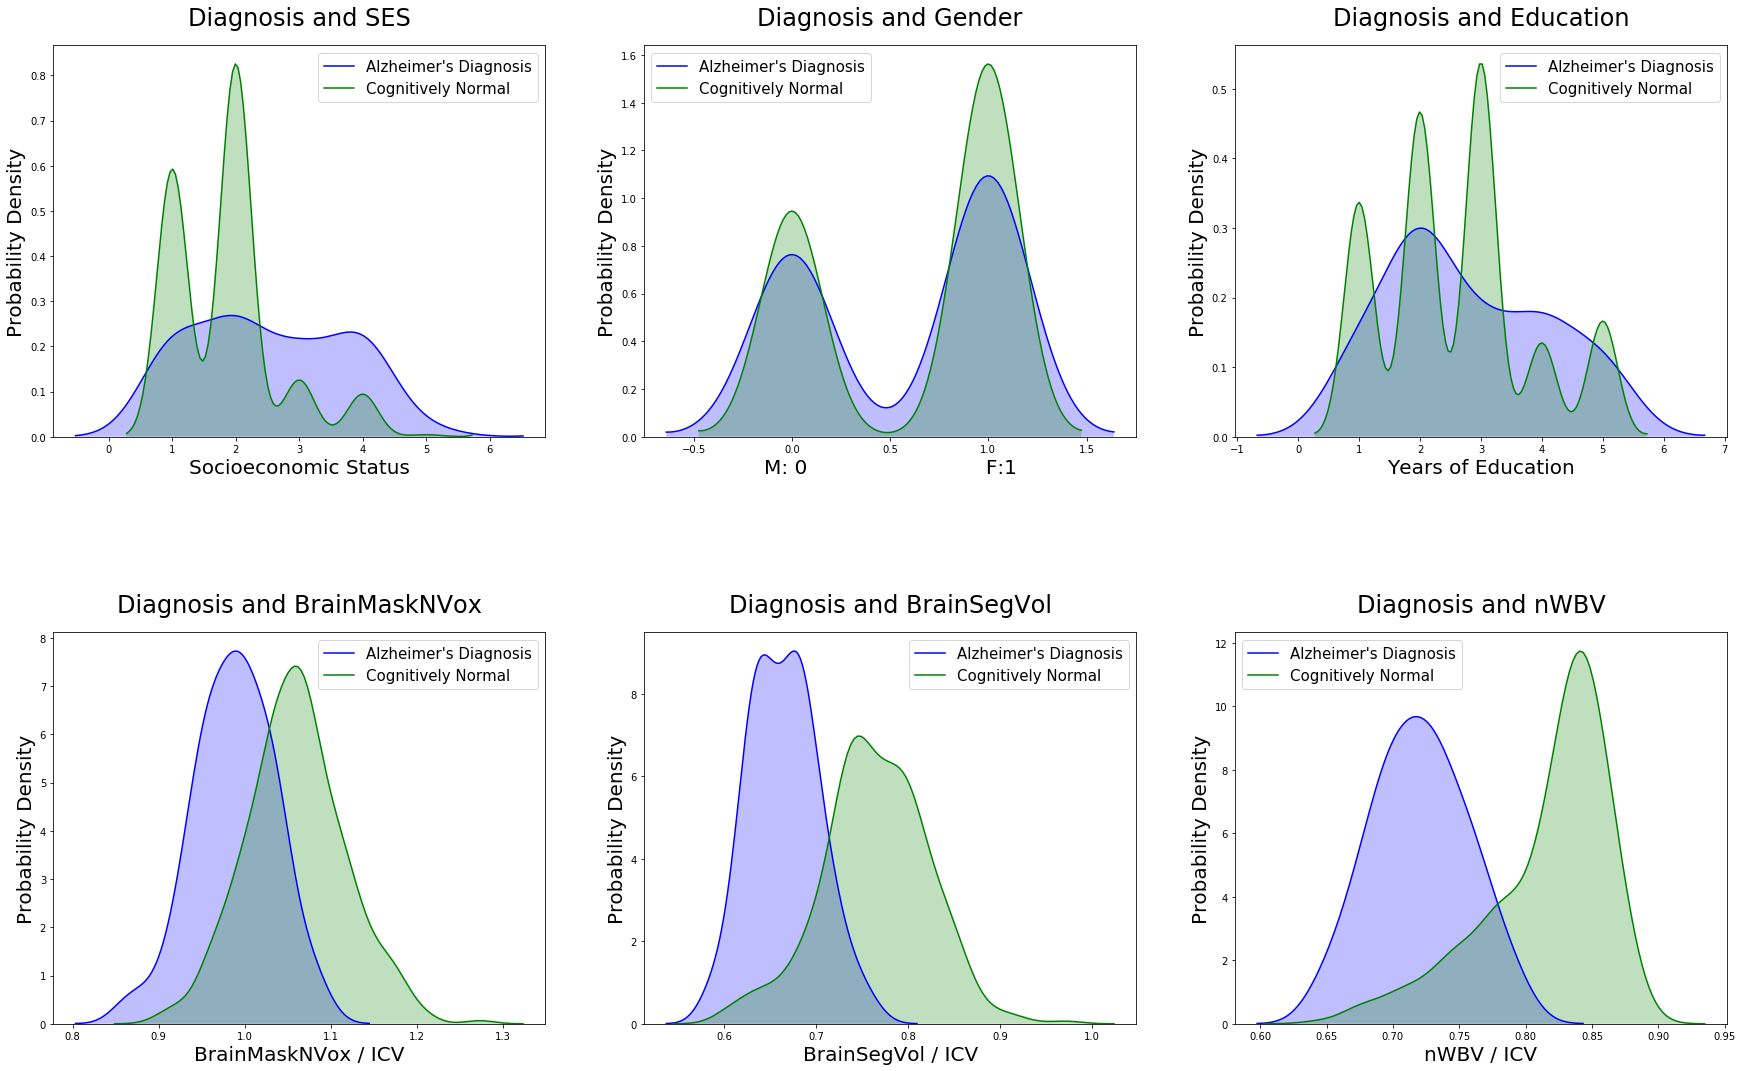

In [41]:
healthy = 'Cognitively Normal'
dementia = 'Alzheimer\'s Diagnosis'

fig = plt.figure(figsize=(30, 18))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.5)

plt.subplot(grid[0, 0])
ax = sns.kdeplot(merge[merge['Diagnosis']==1.0].SES, label = dementia, color='blue', shade=True)
ax = sns.kdeplot(merge[merge['Diagnosis']==0.0].SES, label = healthy, color ='green', shade=True)
ax.legend(fontsize=15)
plt.xlabel('Socioeconomic Status', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.set_title('Diagnosis and SES', fontsize=24, pad = 20)

plt.subplot(grid[0, 1])
ax1 = sns.kdeplot(merge[merge['Diagnosis']==1.0]['M/F'], label = dementia, color='blue', shade=True)
ax1 = sns.kdeplot(merge[merge['Diagnosis']==0.0]['M/F'], label = healthy, color='green', shade=True)
ax1.legend(fontsize=15)
plt.xlabel('M: 0                            F:1', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.set_title('Diagnosis and Gender', fontsize=24, pad = 20)

plt.subplot(grid[0, 2])
ax2 = sns.kdeplot(merge[merge['Diagnosis']==1.0]['Educ'], label = dementia, color='blue', shade=True)
ax2 = sns.kdeplot(merge[merge['Diagnosis']==0.0]['Educ'], label = healthy, color='green', shade=True)
ax2.legend(fontsize=15)
plt.xlabel('Years of Education', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax2.set_title('Diagnosis and Education', fontsize=24, pad = 20)


plt.subplot(grid[1, 0])
ax = sns.kdeplot(merge[merge['Diagnosis']==1.0].BrainMaskNVox, label = dementia, shade=True, color='blue')
ax = sns.kdeplot(merge[merge['Diagnosis']==0.0].BrainMaskNVox, label = healthy, shade=True, color ='green')
plt.xlabel('BrainMaskNVox / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax.legend(fontsize=15)
ax.set_title('Diagnosis and BrainMaskNVox', fontsize=24, pad = 20)

plt.subplot(grid[1, 1])
ax1 = sns.kdeplot(merge[merge['Diagnosis']==1.0].BrainSegVol, label = dementia, shade=True,color='blue')
ax1 = sns.kdeplot(merge[merge['Diagnosis']==0.0].BrainSegVol, label = healthy, shade=True,color='green')
plt.xlabel('BrainSegVol / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and BrainSegVol', fontsize=24, pad = 20)

plt.subplot(grid[1, 2])
ax1 = sns.kdeplot(merge[merge['Diagnosis']==1.0].nWBV, label = dementia, shade=True,color='blue')
ax1 = sns.kdeplot(merge[merge['Diagnosis']==0.0].nWBV, label = healthy, shade=True,color='green')
plt.xlabel('nWBV / ICV', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
ax1.legend(fontsize=15)
ax1.set_title('Diagnosis and nWBV', fontsize=24, pad = 20)

In [42]:
del merge['CDR']
del merge['ICV']

In [43]:
merge.corr()

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
BrainMaskNVox,1.000000,0.853737,-0.458426,0.192896,-0.168938,-0.206898,0.633107
BrainSegVol,0.853737,1.000000,-0.588861,0.068448,-0.258682,-0.299486,0.870244
Diagnosis,-0.458426,-0.588861,1.000000,-0.027878,0.065137,0.294147,-0.646117
M/F,0.192896,0.068448,-0.027878,1.000000,0.000529,0.099705,0.013238
Educ,-0.168938,-0.258682,0.065137,0.000529,1.000000,-0.226909,-0.266159
SES,-0.206898,-0.299486,0.294147,0.099705,-0.226909,1.000000,-0.379147
nWBV,0.633107,0.870244,-0.646117,0.013238,-0.266159,-0.379147,1.000000


In [44]:
healthy = merge[merge['Diagnosis'] ==0]
AD = merge[merge['Diagnosis'] ==1]
healthy.describe() # look at values descriptive of healthy patients

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,366.000000,366.000000,366.0,366.000000,366.000000,366.000000,366.000000
mean,1.059237,0.764235,0.0,0.622951,2.590164,1.838798,0.816041
std,0.057157,0.057601,0.0,0.485311,1.194192,0.816758,0.047084
min,0.898880,0.598557,0.0,0.000000,1.000000,1.000000,0.645000
25%,1.023978,0.731177,0.0,0.000000,2.000000,1.000000,0.790000
50%,1.059949,0.767107,0.0,1.000000,3.000000,2.000000,0.832000
75%,1.093218,0.803540,0.0,1.000000,3.000000,2.000000,0.848000
max,1.273024,0.971192,0.0,1.000000,5.000000,5.000000,0.893000


In [45]:
AD.describe() # look at values descriptive of AD patients

,BrainMaskNVox,BrainSegVol,Diagnosis,M/F,Educ,SES,nWBV
count,90.000000,90.000000,90.0,90.000000,90.000000,90.000000,90.000000
mean,0.987884,0.665273,1.0,0.588889,2.788889,2.533333,0.720322
std,0.046183,0.036979,0.0,0.494792,1.293844,1.182266,0.035844
min,0.862992,0.585271,1.0,0.000000,1.000000,1.000000,0.644000
25%,0.954502,0.637523,1.0,0.000000,2.000000,2.000000,0.694000
50%,0.990088,0.665270,1.0,1.000000,2.000000,2.000000,0.720000
75%,1.024725,0.687975,1.0,1.000000,4.000000,4.000000,0.745000
max,1.084934,0.761927,1.0,1.000000,5.000000,5.000000,0.797000


In [46]:
Counter(merge['Diagnosis']) # balance the dataset

Counter({0: 366, 1: 90})

In [47]:
merge_AD = merge.sort_values(by='Diagnosis', ascending=False).head(90)
merge_AD_short = merge.sort_values(by='Diagnosis', ascending=False).head(6)

In [48]:
merge = merge.append(merge_AD)
merge = merge.append(merge_AD)
merge = merge.append(merge_AD)
merge = merge.append(merge_AD_short)

In [49]:
Counter(merge['Diagnosis']) # confirtm balanced set

Counter({0: 366, 1: 366})

# Prediction with Random Forest Classifier

In [50]:
X_text = merge.drop("Diagnosis", axis=1)
y = merge["Diagnosis"]
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y, random_state = 42)

In [51]:
RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)
RanFor.fit(X_text_train,y_text_train)
print ("Training score: " + str(round(RanFor.score(X_text_train,y_text_train)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(X_text_test,y_text_test)*100,2)) + '%')

Training score: 89.25%
Test score: 87.98%


In [52]:
random_trees, random_depths =  random.sample(range(1,30),10), random.sample(range(1,50),25)

In [53]:
random_depth =  random.sample(range(1,30),10)

In [54]:
grid = GridSearchCV(RanFor, 
        param_grid={'max_depth': random_trees, 'n_estimators': random_depths},
        scoring='accuracy', 
        n_jobs=1,
        cv=5
        )

grid.fit(X_text_train,y_text_train)
print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 93.81% {'max_depth': 13, 'n_estimators': 6}


In [55]:
X_text_train.head(2)

,BrainMaskNVox,BrainSegVol,M/F,Educ,SES,nWBV
Subject,,,,,,
OAS1_0243,0.992222,0.649189,0,5,2,0.742
OAS1_0134,0.983676,0.634772,0,2,4,0.665


In [56]:
final_model = grid.best_estimator_
final_model.fit(X_text_train,y_text_train)

print ("Training score: " + str(final_model.score(X_text_train,y_text_train)))
print ("Test score: " + str(final_model.score(X_text_test,y_text_test)))

Training score: 0.9908925318761385
Test score: 0.9508196721311475


In [57]:
RF_txt_vol_accuracy = round(final_model.score(X_text_test,y_text_test)*100,2)
txt_vol_pred = final_model.predict(X_text_test)
RF_txt_vol_recall = round((recall_score(y_text_test, txt_vol_pred))*100, 2)
RF_txt_vol_precision = round(precision_score(y_text_test, txt_vol_pred)*100, 2)

In [58]:
estimator = final_model.estimators_[5]

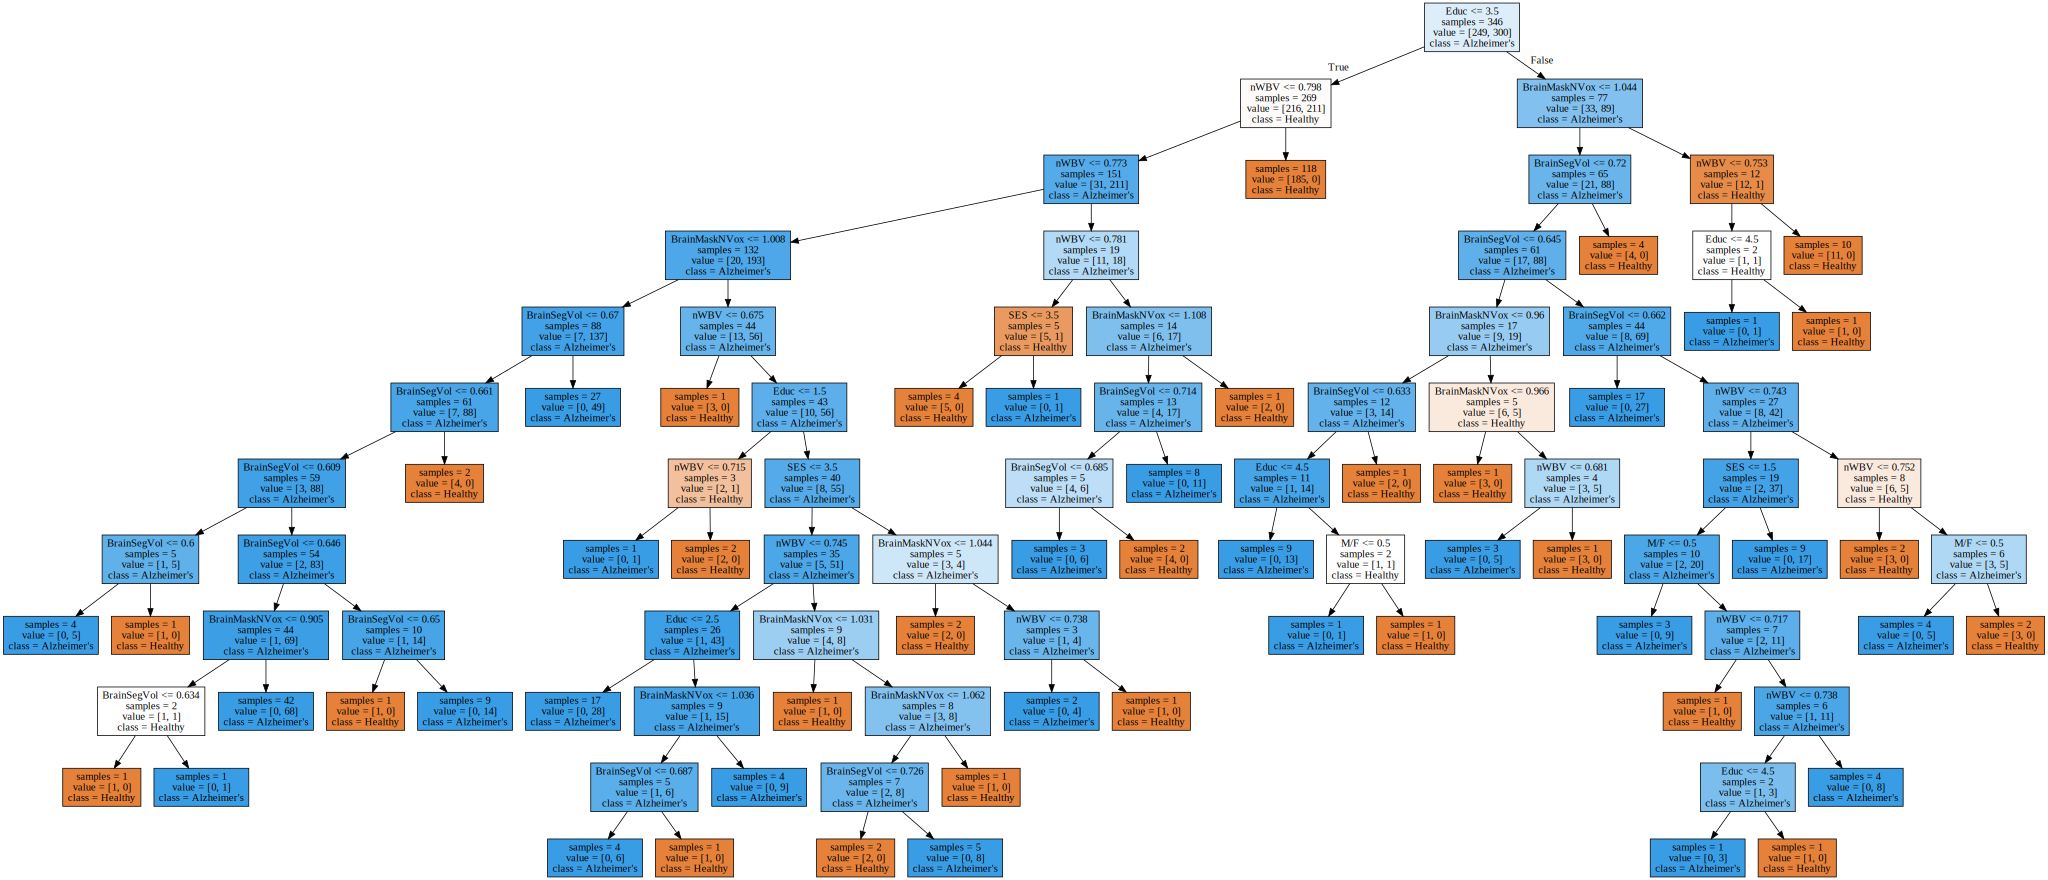

In [59]:
# visualize the split decisions in notebook
tree = export_graphviz(estimator, out_file=None, 
                class_names=["Healthy", "Alzheimer's"], 
                feature_names=['BrainMaskNVox','BrainSegVol','M/F','Educ','SES','nWBV'],
                impurity=False,
                filled=True)

graph = graphviz.Source(tree)
graph.render('DecTree')  # creates PDF
graph  # show in notebook

## Results

Finally, I compare the output of the NNs trained on fMRI images (alone or with PCA or t-SNE for dimensionality reduction) with the Random Forest Classifer trained on brain volumes and categorical descriptors of the subjects.

In [60]:
result_df = pd.DataFrame({
    'Model': ['CNN','T-SNE + NN','PCA + NN','Demographic Data + RF'],
    'Accuracy': [model_accuracy,tsne_accuracy,PCA_accuracy, RF_txt_vol_accuracy],
    'Precision': [model_precision,tsne_precision,PCA_precision, RF_txt_vol_precision],
    'Recall': [model_recall,tsne_recall,PCA_recall, RF_txt_vol_recall]
 })
result_df = result_df.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Accuracy,Precision,Recall
Model,,,
PCA + NN,95.21,91.30,100.00
Demographic Data + RF,95.08,90.22,100.00
CNN,89.82,83.84,98.81
T-SNE + NN,87.43,84.62,91.67


In [61]:
result_df.style.background_gradient(cmap='GnBu', low=1, high=0.75, axis=0).set_properties(**{'font-size':'15pt'})

,Accuracy,Precision,Recall
Model,,,
PCA + NN,95.21,91.3,100
Demographic Data + RF,95.08,90.22,100
CNN,89.82,83.84,98.81
T-SNE + NN,87.43,84.62,91.67
